## <center><b>Evaluation of SBF120 Stocks Portfolios Performance</b></center>

This project presents a comparison of the performance of different portfolios composed of the top 10 stocks from SBF120 - index involving 120 largest stocks from the Paris Euronext exchange. The performance is evaluated for the year 2019, and the constructed portfolios are the following:
- Equally-weighted portfolio - portfolio with equal weights assigned to each stock
- Markovitz minimum-variance portfolio - portfolio with weights minimizing its variance for the covariance matrix calibrated over the years 2017-18 (i.e., portfolio corresponding to the leftmost point on the efficient frontier curve)
- Equally-weighted Risk Contributions portfolio - portfolio with weights proportional to the contribution of each stock to the total variance of the portfolio for the covariance matrix calibrated over the years 2017-18

For each portfolio, the evolution of the value over time is plotted, and Sharpe ratio, as well as maximal drawdown, are obtained.

Libraries

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)
from scipy.optimize import minimize

Fetching data

In [5]:
data = pd.read_excel('sbf120_as_of_end_2018.xlsx', sheet_name = 'Data')

Transform the initial dataset into a Pandas dataframe containing prices with dates as index and tickers as columns 

In [21]:
price_df_list = []
for i in range(120):
    price_data = data.iloc[:,3*i:3*i+2].copy()
    price_data.dropna(inplace = True)
    price_data['Date'] = pd.to_datetime(price_data.iloc[:,0], unit = 'D', origin = '1899-12-30', errors = 'coerce')
    eq_name = price_data.columns[0]
    price_data.drop(columns = eq_name, inplace = True)
    price_data.set_index('Date', inplace = True)
    price_data.columns = [eq_name]
    price_df_list.append(price_data)

agg_price_data = price_df_list[0]
for df in price_df_list[1:]:
    agg_price_data = agg_price_data.join(df, how = 'outer', sort = True)

Transform the initial dataset into a Pandas dataframe containing market capitaliation with dates as index and tickers as columns 

In [23]:
df_mkt_cap_list = []
for i in range(120):
    mkt_cap_data = data.iloc[:,[3*i,3*i+2]].copy()
    mkt_cap_data.dropna(inplace = True)
    mkt_cap_data['Date'] = pd.to_datetime(mkt_cap_data.iloc[:,0], unit = 'D', origin = '1899-12-30', errors = 'coerce')
    eq_name = mkt_cap_data.columns[0]
    mkt_cap_data.drop(columns = eq_name, inplace = True)
    mkt_cap_data.set_index('Date', inplace = True)
    mkt_cap_data.columns = [eq_name]
    df_mkt_cap_list.append(mkt_cap_data)

agg_mkt_cap_data = df_mkt_cap_list[0]
for df in df_mkt_cap_list[1:]:
    agg_mkt_cap_data = agg_mkt_cap_data.join(df, how = 'outer', sort = True)

Main Pandas dataframes

In [24]:
agg_price_data

,QDT FP Equity,DIM FP Equity,RUI FP Equity,OR FP Equity,DG FP Equity,ALD FP Equity,URW NA Equity,KORI FP Equity,TTE FP Equity,DSY FP Equity,...,ATO FP Equity,MDM FP Equity,AKE FP Equity,MERY FP Equity,RI FP Equity,RCO FP Equity,STM FP Equity,ATE FP Equity,WLN FP Equity,NXI FP Equity
Date,,,,,,,,,,,,,,,,,,,,,
2010-12-31,65.20,6.28,21.1225,83.08,40.2799,NaN,145.441,15.1940,39.650,5.642,...,30.1261,NaN,52.0002,15.6662,70.36,51.1749,7.739,24.585,NaN,26.4957
2011-01-03,65.41,6.29,21.3261,85.50,41.3097,NaN,147.799,15.4988,40.590,5.672,...,30.6517,NaN,52.3960,15.7219,71.13,51.4648,8.081,24.700,NaN,26.8603
2011-01-04,66.54,6.28,21.3770,85.04,41.0176,NaN,146.669,15.5635,41.130,5.711,...,30.2093,NaN,52.0485,15.7191,69.90,51.2522,8.096,25.090,NaN,27.2288
2011-01-05,66.51,6.29,21.6896,84.66,40.4730,NaN,144.900,15.6651,41.290,5.669,...,30.4513,NaN,51.4500,16.0007,68.90,52.0833,8.287,25.000,NaN,27.1047
2011-01-06,67.56,6.30,21.6920,84.57,39.9878,NaN,143.721,15.8128,41.550,5.689,...,30.4778,NaN,51.5465,15.8669,68.74,51.3198,8.406,25.450,NaN,27.1861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,23.72,524.20,33.2700,399.50,93.7500,11.88,73.580,33.8600,37.100,49.155,...,45.7400,19.47,111.5500,9.9900,184.55,170.0000,37.920,138.700,75.99,43.5800
2021-09-02,23.76,532.60,33.2000,400.15,92.9800,11.86,72.250,32.4000,37.580,49.020,...,45.5000,19.33,111.1000,9.7000,186.05,170.9000,37.935,139.900,75.01,43.3600
2021-09-03,23.28,531.00,32.9700,394.85,91.1400,11.68,70.140,31.5800,37.265,48.790,...,45.1800,19.09,111.3500,9.6100,183.70,168.6000,37.900,139.800,72.39,43.6600


In [25]:
agg_mkt_cap_data

,QDT FP Equity,DIM FP Equity,RUI FP Equity,OR FP Equity,DG FP Equity,ALD FP Equity,URW NA Equity,KORI FP Equity,TTE FP Equity,DSY FP Equity,...,ATO FP Equity,MDM FP Equity,AKE FP Equity,MERY FP Equity,RI FP Equity,RCO FP Equity,STM FP Equity,ATE FP Equity,WLN FP Equity,NXI FP Equity
Date,,,,,,,,,,,,,,,,,,,,,
2010-12-31,2074.1424,640.6889,1224.8148,49784.4831,22463.6902,NaN,13574.0125,528.1141,93138.4018,6750.9914,...,2782.3078,NaN,3305.5440,2584.3429,18592.8190,2603.4359,7045.2320,785.1392,NaN,1770.6669
2011-01-03,2080.8229,641.5386,1236.6203,51234.6330,23037.9831,NaN,13794.1317,538.7085,95346.4749,6786.8882,...,2830.8446,NaN,3330.7022,2593.5398,18796.2935,2618.1862,7356.5732,788.8118,NaN,1795.0327
2011-01-04,2116.7705,640.6889,1239.5716,50958.9847,22875.0827,NaN,13688.6579,540.9557,96614.9424,6833.5541,...,2789.9899,NaN,3308.6121,2593.0800,18471.2627,2607.3693,7370.2285,801.2667,NaN,1819.6576
2011-01-05,2115.8161,641.3687,1257.7014,50731.2752,22571.3701,NaN,13523.5686,544.4872,96990.7846,6783.2985,...,2812.3359,NaN,3270.5679,2639.5246,18207.0100,2649.6536,7544.1062,798.3925,NaN,1811.3629
2011-01-06,2149.2187,642.3883,1257.8420,50677.3440,22317.5758,NaN,13413.5090,549.6239,97601.5282,6807.2297,...,2814.7802,NaN,3276.7041,2617.4519,18164.7296,2610.8110,7652.4383,812.7636,NaN,1816.8063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,819.8323,48320.8556,3459.1215,222789.8633,56029.0137,4800.7512,10197.7771,3575.3571,97959.9281,65402.6198,...,5031.0874,880.8597,8559.9539,937.9261,48329.3191,8589.5157,34554.1988,4765.8506,21312.5103,2446.1334
2021-09-02,821.2148,49095.1692,3451.8435,223152.3500,55568.8288,4792.6692,10013.4466,3421.1922,99227.3342,65222.9971,...,5004.6891,874.5258,8525.4225,910.6991,48722.1340,8634.9896,34567.8674,4807.0836,21037.6549,2433.7848
2021-09-03,804.6246,48947.6809,3427.9301,220196.6897,54469.1660,4719.9305,9721.0123,3334.6065,98395.5989,64916.9733,...,4969.4912,863.6678,8544.6066,902.2493,48106.7241,8518.7785,34535.9740,4803.6475,20302.8375,2450.6237


Choose 10 stocks with the highest capitalization as of the end 2018

In [26]:
# pick stocks capitalization from the end of 2018 and sort it
a = pd.DataFrame(agg_mkt_cap_data.loc['2018-12-31'])
a.rename(columns = {a.columns[0]: 'mkt_cap'}, inplace = True)
a.sort_values("mkt_cap", ascending = False, inplace = True)

# pick 10 with the highest capitalization
tickers = list(a.iloc[0:10,].index)

# prices data for 2017-18
agg_price_data_top10_2017_18 = agg_price_data[tickers].loc['2017-01-01':'2018-12-31']

# prices data for 2019
agg_price_data_top10_2019 = agg_price_data[tickers].loc['2018-12-31':'2019-12-31']

Check if there are any missing values

In [27]:
[agg_price_data_top10_2017_18.isnull().values.any(),
agg_price_data_top10_2019.isnull().values.any()]      # OK

[False, False]

Obtain variance-covariance matrix of the returns in years 2017-18

In [47]:
cov_mtx = agg_price_data_top10_2017_18.pct_change(fill_method = None).cov()

#### Equally-weighted portfolio

In [48]:
# create a data frame for number of shares of each stock
portfolio_ew = pd.DataFrame(np.zeros((len(agg_price_data_top10_2019.index[1:]), 10)), columns = tickers)
portfolio_ew.set_index(agg_price_data_top10_2019.index[1:], inplace = True)

# create a data frame for the value of the portfolio along the time
port_ew_val = pd.DataFrame(np.zeros((len(agg_price_data_top10_2019.index[1:]), 2)), columns = ["Portfolio value", "Returns"])
port_ew_val.set_index(agg_price_data_top10_2019.index[1:], inplace = True)

Loop updating portfolio structure and it's value in each period

In [57]:
# set starting values
portfolio_ew.iloc[0, :] = ((100 / 10) / agg_price_data_top10_2019).iloc[0, :]
port_ew_val.iloc[0, 0] = sum((agg_price_data_top10_2019.iloc[1, :] * portfolio_ew.iloc[0, :]))

for i in range(1, len(port_ew_val), 1):
    port_val_prev = port_ew_val.iloc[i - 1, 0]
    portfolio_ew.iloc[i, :] = ((port_val_prev / 10) / agg_price_data_top10_2019).iloc[i, :]       # spend equal amount for each stock (beginning of the period)
    port_val = sum((agg_price_data_top10_2019.iloc[i + 1, :] * portfolio_ew.iloc[i, :]))          # update portfolio's value (end of the period)
    port_ew_val.iloc[i, 0] = port_val
    port_ew_val.iloc[i, 1] = (port_ew_val.iloc[i, 0] - port_ew_val.iloc[i - 1, 0]) / port_ew_val.iloc[i - 1, 0]
port_ew_val.iloc[0, 1] = np.nan

#### Markovitz minimum-variance portfolio

Compute weights minimizing portfolio's variance

In [52]:
# compute weights that minimize portfolio's variance
cov_mtx_inv = np.linalg.inv(cov_mtx)
mmv_weights = np.matmul(cov_mtx_inv, np.ones(10)) / np.matmul(np.matmul(np.ones(10), cov_mtx_inv), np.ones(10))
# some of them are negative, which means that some stocks must be shorted

Construct the portfolio and compute it's value in each period

In [60]:
# compute number of shares of each stock to buy at the beginning of the period
portfolio_mmv = (100 * mmv_weights) / agg_price_data_top10_2019.iloc[0, :]

# create a data frame for the value of the portfolio along the time
port_mmv_val = pd.DataFrame(np.zeros((len(agg_price_data_top10_2019.index[1:]), 2)), columns = ["Portfolio value", "Returns"])
port_mmv_val.set_index(agg_price_data_top10_2019.index[1:], inplace = True)

# update portfolio value in each period
for i in range(len(port_mmv_val)):
    port_val = sum((agg_price_data_top10_2019.iloc[i + 1, :] * portfolio_mmv))
    port_mmv_val.iloc[i, 0] = port_val
    
port_mmv_val['Returns'] = port_mmv_val["Portfolio value"].pct_change()

#### Equally-weighted Risk Contributions (ERC) portfolio

Compute weights satisfying equalilty of risk conribution

In [62]:
# function computing sum of squares of differences between risk contributions of assets in a given portfolio and desired risk conributions
def cost_func(x, big_sigma):
    small_sigma = np.sqrt(np.matmul(np.matmul(x, big_sigma), x))
    delta_sm_sig = np.matmul(x, big_sigma) / small_sigma
    RC = x * delta_sm_sig
    J = sum((RC - (np.ones(10) * 0.1) * small_sigma) ** 2)
    return J

# sum of weights equal to 1 constraint
def total_weight_constraint(x):
    return sum(x) - 1.0

# minimize the output of the cost function 
res = minimize(cost_func, np.ones(10) * 0.1, args = cov_mtx, constraints = ({'type': 'eq', 'fun': total_weight_constraint}), tol = 1e-22)
erc_weights = res.x

Construct the portfolio and compute it's value in each period

In [63]:
# compute number of shares of each stock to buy at the beginning of the period
portfolio_erc = (100 * erc_weights) / agg_price_data_top10_2019.iloc[0, :]

# create a data frame for the value of the portfolio along the time
port_erc_val = pd.DataFrame(np.zeros((len(agg_price_data_top10_2019.index[1:]), 2)), columns = ["Portfolio value", "Returns"])
port_erc_val.set_index(agg_price_data_top10_2019.index[1:], inplace = True)

# update portfolio value in each period
for i in range(len(port_erc_val)):
    port_val = sum((agg_price_data_top10_2019.iloc[i + 1, :] * portfolio_erc))
    port_erc_val.iloc[i, 0] = port_val
    
port_erc_val['Returns'] = port_erc_val["Portfolio value"].pct_change()

#### Performance metrics

Sharpe ratio (annualized);
as a risk free rate EONIA average from 2019 is chosen - equal to -0.392% (source: https://www.global-rates.com/fr/taux-de-interets/eonia/2019.aspx )

In [64]:
# equally-weighted portfolio
sharpe_ratio_ew = np.sqrt(len(port_ew_val) - 1) * (np.mean(port_ew_val["Returns"]) - (-0.00392 / 365)) / np.sqrt(np.var(port_ew_val["Returns"]))

# Markowitz minimum-variance portfolio
sharpe_ratio_mmv = np.sqrt(len(port_mmv_val) - 1) * (np.mean(port_mmv_val["Returns"]) - (-0.00392 / 365)) / np.sqrt(np.var(port_mmv_val["Returns"]))

# ERC portfolio
sharpe_ratio_erc = np.sqrt(len(port_erc_val) - 1) * (np.mean(port_erc_val["Returns"]) - (-0.00392 / 365)) / np.sqrt(np.var(port_erc_val["Returns"]))

Maximum drawdown

In [65]:
def mdd(pnl):
    return 1. - np.min(np.flip(np.minimum.accumulate(np.flip(pnl))) / pnl)

# equally-weighted portfolio
mdd_ew = mdd(port_ew_val["Portfolio value"])

# Markowitz minimum-variance portfolio
mdd_mmv = mdd(port_mmv_val["Portfolio value"])

# ERC portfolio
mdd_erc = mdd(port_erc_val["Portfolio value"])

#### Graphs

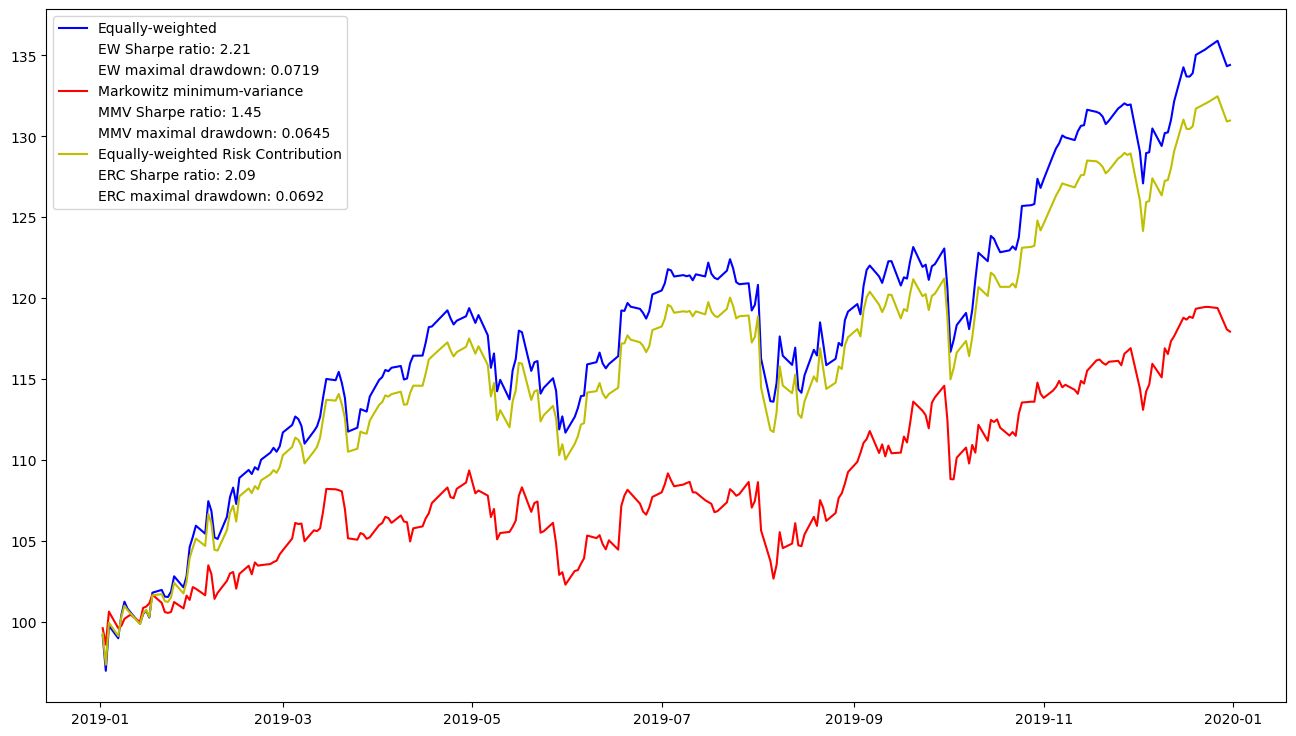

In [74]:
plt.plot(port_ew_val["Portfolio value"], 'b', label = 'Equally-weighted')
plt.plot([], [], ' ', label = f"EW Sharpe ratio: {round(sharpe_ratio_ew, 2)}")
plt.plot([], [], ' ', label = f"EW maximal drawdown: {round(mdd_ew, 4)}")
plt.plot(port_mmv_val["Portfolio value"], 'r', label = 'Markowitz minimum-variance')
plt.plot([], [], ' ', label = f"MMV Sharpe ratio: {round(sharpe_ratio_mmv, 2)}")
plt.plot([], [], ' ', label = f"MMV maximal drawdown: {round(mdd_mmv, 4)}")
plt.plot(port_erc_val["Portfolio value"], 'y', label = 'Equally-weighted Risk Contribution')
plt.plot([], [], ' ', label = f"ERC Sharpe ratio: {round(sharpe_ratio_erc, 2)}")
plt.plot([], [], ' ', label = f"ERC maximal drawdown: {round(mdd_erc, 4)}")
plt.legend()
plt.show()